In [1]:
# !pip install openpyxl            #to read .xlsx format files
import numpy as np
import pandas as pd
import time
import math
import itertools
from random import randint
import random
from itertools import chain
import matplotlib.pyplot as plt
%matplotlib inline

In [17]:
#=============================== Let's get data information =================================================
def dataset_info():
    '''this function reads the information about all datas
       and returns informations as a pandas table BKS'''   
    #readin excel format file with pandas
    BKS =  pd.read_excel('BKS.xlsx', sheet_name='BKS')
    #rename the features
    BKS.rename(columns={'Ins':'file_name', 'n':'Nom_of_node', 'K':'K_min', 'Q':'veh_cap'}, inplace=True)
    # Add '.txt' to file_name values
    for i in range(30):
        BKS.loc[i,'file_name'] = BKS.loc[i,'file_name']+str('.txt')
    return BKS


#================================ reading all text files ========================================================
def get_files(info):
    ''' This function reads all text files and pass them to a dictionary'''
    # Reading each file.txt as a table an save all them in a dictionary
    File_Name_dic = {}
    rows= info.index.tolist()
    for row in rows:
        File_Name_dic['data'+str(row)] = pd.read_table(info.loc[row, 'file_name'])
    return rows, File_Name_dic



# ======================== Extracting Tables from each File ====================================================
def get_table(BKS, File_Name_dic,rows):
    ''' Extracts tables from text files and saves them as dictionaries'''  
    Locations={}
    Demands = {} 
    # defining some parameters for slicing 
    L_N = 6+BKS['Nom_of_node']
    D_N_L = L_N+2
    D_N_U = D_N_L + BKS['Nom_of_node']
    # reading cotumers' location and costumers' demand from each file
    for row in rows:
        Locations['loc'+str(row)] = File_Name_dic['data'+str(row)].loc[6:L_N[row]]
        col2 = str(Locations['loc'+str(row)].columns[1])
        Locations['loc'+str(row)].rename(columns={'NAME : ':'ind',col2:'x','Unnamed: 2':'y'}, inplace=True)
        Locations['loc'+str(row)].set_index('ind', inplace=True)
        Demands['dem'+str(row)] = File_Name_dic['data'+str(row)].loc[D_N_L[row]:D_N_U[row]]
        Demands['dem'+str(row)].rename(columns={'NAME : ':'ind',col2:'d'}, inplace=True)
        Demands['dem'+str(row)].set_index('ind', inplace=True)
        Demands['dem'+str(row)].drop('Unnamed: 2',axis=1, inplace=True)
    return Locations, Demands


# ======================== coordinates of clients ====================================================
def coordinates(df, BKS):
    '''return coordinates all points'''
    depo = df.iloc[0,:]
    x_d, y_d = depo[0], depo[1]
    x_c, y_c = df['x'][1:], df['y'][1:]
    return x_d, y_d, x_c, y_c


# ======================== Initial route ========================================================
def Initial_solution(cust_list, n, d, Q, dist,popsize ): 
    pop = {}  
    H = [l for l in range(n+1)]
    coord_h = [(s,w) for s in H for w in H if s!=w]
    Y = {(m,n):dist[(m,n)] for m,n in coord_h}
    for f in range(popsize):
        Initial_Rout={}
        all_checked = [False for c in range(1, n+1)]
        j = 0
        Initial_Rout[j] = [0]
        node_visited_init = [0]
        r = random.sample(H, 1)[0]
        Initial_Rout[j].append(r)
        node_visited_init.append(r)
        all_checked[r-1] = True
        while sum(all_checked)!= n:
            a = Initial_Rout[j][-1]
            my_list = {}
            for b in H:
                if b not in node_visited_init:
                    if b!=a:
                        my_list[b]=Y[(a,b)]
            my_list_as = {k: v for k, v in sorted(my_list.items(), key=lambda item: item[1])}
            my_list_key = list(my_list_as.keys())
            my_list_value = list(my_list_as.values())
            index = 0
            node_ass = False
            rout_deman = [d[s] for s in Initial_Rout[j]]
            u = np.sum(rout_deman)
            while node_ass == False and index<=3:
                visit = my_list_key[index]
                if all_checked[visit-1]==False:
                    if u+d[visit] <= Q:
                        Initial_Rout[j].append(visit)
                        all_checked[visit-1]=True
                        u = u+d[visit]
                        a = visit
                        node_visited_init.append(visit)
                        node_ass = True
                        break
                index+=1
                if index >=len(my_list_key):
                    break
            node_not_visited = [e for e in H if e not in node_visited_init]
            node_not_vi_dem = [d[t] for t in node_not_visited]
            rout_deman = [d[w] for w in Initial_Rout[j]]
            slack = Q - np.sum(rout_deman)
            try:
                if slack < min(node_not_vi_dem) or index >=3:
                    j+=1
                    Initial_Rout[j] =[0]
                    r = random.sample(node_not_visited, 1)[0]
                    Initial_Rout[j].append(r)
                    node_visited_init.append(r)
                    all_checked[r-1] = True
            except: ValueError
        pop[f]=Initial_Rout
    return pop

# ======================== computr Route cost ====================================================
def comput_cost(D, active):
    '''to compute objective or loss function'''
    Total_cost = 0
    for i,j in active:
        Total_cost +=D[i,j]
    return Total_cost

# ======================== network graph ====================================================
def active_graph(Rout, cr):
    ''' Gets route and and return active arcs in netwark'''
    
    Y = {(i,j):0 for i,j in cr}  #Binary variable is 1 if vehicle visits client j after visiting client i 
    for key in Rout.keys():
        for i in range(len(Rout[key])):
            if Rout[key][i] == Rout[key][-1]:
                j=0
            else: j = Rout[key][i+1]
            Y[Rout[key][i], j]=1
    active_arcs = [i for i in cr if Y[i]>0]
    return active_arcs,Y

# ======================== Get route  ====================================================
def get_route(client_priority,n, d, Q ):
    cp =client_priority
    Initial_Route = {}   
    is_visited = [False for i in range(n)]
    j=0
    # for each customer checks the capacity feasibility of a route and assigns it
    while sum(is_visited)!=n:
        u = 0
        Initial_Route[j] = [0]
        for i in cp:
            if is_visited[i-1]==False:
                if u+d[i] <= Q:
                    Initial_Route[j].append(i)
                    is_visited[i-1]=True
                    u = u+d[i]
                else: break
        j+=1
    return Initial_Route


# ======================== Mutation====================================================
def Mutation(List,dis,cl):
    Mutation_size = 10
    for i in range(Mutation_size):
        MM1 = List
        mutationIndex1 = random.sample(MM1, 1)[0]
        X = {(mutationIndex1, b):dis[(mutationIndex1, b)] for b in cl if b!=mutationIndex1}
        X = {k:v for k,v in sorted(X.items(), key= lambda item:item[1])}
        bestmutationIndex2 = list(dict(itertools.islice(X.items(),1)))[0][1]
        mutationIndex1 = MM1.index(mutationIndex1)
        bestmutationIndex2 = MM1.index(bestmutationIndex2)
        temp = MM1[mutationIndex1]
        MM1[mutationIndex1] = MM1[bestmutationIndex2]
        MM1[bestmutationIndex2] = temp
    return MM1

# ======================== Reading data ====================================================
def get_data_information(Instance):
    instance = Instance-1
    data_information = dataset_info()

    rows, Files_name = get_files(data_information)

    Locations, Demands = get_table(data_information, Files_name, rows)

    df = Locations['loc'+str(instance)].astype(float)

    num_of_customer = data_information.loc[instance,'Nom_of_node']
    
    customer_list = [i for i in range(1,num_of_customer+1 )]

    all_nodes = [i for i in range(num_of_customer+1)]

    coords = [(i,j) for i in all_nodes for j in all_nodes if i!=j]

    distance = {(i,j): round(math.dist((df['x'][i],df['y'][i]), (df['x'][j],df['y'][j]))) for i,j in coords}

    f_star = data_information.loc[instance, 'UB']

    demand = Demands['dem'+str(instance)]['d'].astype(float)           

    capacity = data_information.loc[instance,'veh_cap']

    K_min = data_information.loc[instance,'K_min']

    parameters = {'data_information':data_information,
                  'location':df,
                  'distance':distance,
                  'num_of_customer':num_of_customer,
                  'customer_list': customer_list,
                  'all_nodes': all_nodes,
                  'coords': coords,
                  'distance': distance,
                  'f_star':f_star,
                  'demand': demand,
                  'capacity': capacity,
                  'K_min': K_min}
    return parameters


# ======================== Initial population ====================================================
def Initial_population(data_params, pop_size):
    loc = data_params['location']
    n   = data_params['num_of_customer']
    cl  = data_params['customer_list']
    al  = data_params['all_nodes']
    cr  = data_params['coords']
    fs  = data_params['f_star']
    d   = data_params['demand']
    dis = data_params['distance']
    Q   = data_params['capacity']
    kmin= data_params['K_min']
    NCC=0
    population = {}
    population = Initial_solution(cl, n, d, Q, dis, pop_size)
    pop_fitnes = {}
    for i in population.keys():
        GRAPH,y = active_graph(population[i],cr)
        Cost = comput_cost(dis, GRAPH)
        NCC+=1
        pop_fitnes[Cost] = population[i]
    pop_fitnes = {k: v for k, v in sorted(pop_fitnes.items(), key=lambda item: item[0])}
    return pop_fitnes, NCC

# ======================== Tournament Selection ====================================================
def Tournament_selection(K, Mu, pop_fitnes):
    parents = {}
    for i in range(Mu):
        per = random.sample(pop_fitnes.keys(), K)
        parents[i] = pop_fitnes[min(per)]
    return parents

# ======================== Order_Crossover =========================================================
def Order_Crossover(data_params,parents, mutationRate, crossoverRate,child_size):
    n   = data_params['num_of_customer']
    cl  = data_params['customer_list']
    cr  = data_params['coords']
    d   = data_params['demand']
    dis = data_params['distance']
    Q   = data_params['capacity']
    kmin= Parameters['K_min']
    children = {}
    child_fitnes = {}
    condition = True
    to_count = 0
    NCC=0
    crcbc=0
    oc=0
    MUC=0
    while condition:
        r =  random.sample(parents.keys(), 2)
        parent1 = parents[r[0]]
        parent2 = parents[r[1]]
        P = np.random.uniform()
        if P<=crossoverRate:
            crcbc+=2
            child1 = Best_chromosome(parent1, parent2,cr,dis,n,kmin,cl, d, Q)
            child2 = Best_chromosome(parent2, parent1,cr,dis,n,kmin,cl, d, Q)
            
        else:
            oc+=2
            merge1=[0]
            merge2=[0]
            for j in parent1.values():
                merge1+=j
            new_list1 = np.asarray(merge1)
            M1 =list(dict.fromkeys(new_list1))
            M1.remove(0)
            for h in parent2.values():
                merge2+=h
            new_list2 = np.asarray(merge2)
            M2 =list(dict.fromkeys(new_list2))
            M2.remove(0)
            child1= Crossover(M1, cl, dis)
            child2= Crossover(M2, cl, dis)
            
        if np.random.uniform()<= mutationRate:
            MUC+=1
            child1 = Mutation(child1,dis,cl)
        if np.random.uniform()<= mutationRate:
            child2 = Mutation(child2,dis,cl)
            MUC+=1
            
        child1 = get_route(child1, n, d, Q)
        child2 = get_route(child2, n, d, Q)
        
        children[2*to_count] = child1
        children[2*to_count+1] = child2
        if (2*to_count+1) >= child_size:
              condition = False
        to_count+=1
    for i in children.keys():
        GRAPH,y = active_graph(children[i],cr)
        Cost = comput_cost(dis, GRAPH)
        NCC+=1
        child_fitnes[Cost] = children[i]
    child_fitnes = {k: v for k, v in sorted(child_fitnes.items(), key=lambda item: item[0])}
    return child_fitnes, NCC,crcbc, oc,MUC

# ======================== Survival_Selection =========================================================
def Survival_Selection(child_fitnes, pop_fitnes,pop_size):
    '''Fitness Based Replacement'''
    pop = pop_fitnes
    pop.update(child_fitnes)
    pop = {k:v for k,v in sorted(pop.items() , key=lambda item: item[0])}
    pop = dict(itertools.islice(pop.items(), pop_size)) 
    return pop


def Crossover(A, cl, dis):
    MM1 = A
    Index1 = random.sample(A, 1)[0]
    X = {(Index1, b):dis[(Index1, b)] for b in cl if b!=Index1}
    X = {k:v for k,v in sorted(X.items(), key= lambda item:item[1])}
    Index2 = list(dict(itertools.islice(X.items(),1)))[0][1]
    Index1 = A.index(Index1)
    Index2 = A.index(Index2)
    temp = A[Index1]
    A[Index1] = A[Index2]
    A[Index2] = temp
    return A

# ======================== Survival_Selection =========================================================
def active_Route(Rout, cr):
    ''' Gets route and and return active arcs in netwark'''
    
    Y = {(i,j):0 for i,j in cr}
    for i in range(len(Rout)):
        if Rout[i] == Rout[-1]:
            j=0
        else: j = Rout[i+1]
        Y[Rout[i], j]=1
    active_arcs = [i for i in cr if Y[i]>0]
    return active_arcs

def Best_chromosome(P1, P2, cr, dis, n, kmin,cl, d, Q):
    CH1 = {}
    for i in P2.keys():
        G = active_Route(P2[i], cr)
        C = comput_cost(dis, G)
        CH1[C] = P2[i]
    CH1 = {k:v for k,v in sorted(CH1.items(), key=lambda item:item[0])}
    CHILD1=[]
    JJ = 0
    for i in CH1.keys():
        if len(CH1[i])>=round(n/kmin)-1:
            CHILD1.append(CH1[i])
            JJ+=1
            if JJ>round(0.6*len(CH1.keys())):
                break
    CHILD1=list(chain(*CHILD1))
    CHILD1 = list(dict.fromkeys(CHILD1))
    CHILD1.remove(0)
    Merge1=[]
    for h in P1.values():
        Merge1+=h
    New_list1 = np.asarray(Merge1)
    M_list =list(dict.fromkeys(Merge1))
    M_list.remove(0)
    O = len(CHILD1)
    start=0
    U=0
    while O<=len(M_list)-1:
        X = {(start, IJ):dis[(start, IJ)] for IJ in M_list if IJ not in CHILD1}
        X = {k:v for k,v in sorted(X.items(), key= lambda item:item[1])}
        Ind = list(dict(itertools.islice(X.items(),1)))[0][1]
        U = U +d[Ind]
        if U<=Q:
            CHILD1.append(Ind)
            O+=1
            start=Ind
        else:
            U=0
            start=0
        
    return CHILD1

In [21]:
Instance = 1
Parameters = get_data_information(Instance)
fStar = Parameters['f_star']
Population_size = 80
tournament_size = 7 
parents_size = 70
Mutatuion_Rate = 0.01
Crossover_Rate = 0.9
Child_pop_size = 50
Iteration_Number = 30
Global_Optima_Function=1919191919
No_compute_cost=0
Population_fitens, ncc = Initial_population(Parameters, Population_size)
No_compute_cost = No_compute_cost+ncc
Population = Population_fitens
Stop = True
No_ImprovSoFar = 0
Tic = time.time()
index=1
ha = 0
mutation_counter = 0
Cr_counter_Best_Chromosome = 0
Optimised_Crossover=0
Iteration=0
Loss=[]
Cpu_Time=0
while Stop and Cpu_Time<=1:
    Best_SoFar_Route = list(dict(itertools.islice(Population.items(), 1)).values())[0]
    Best_SoFar_Objective = list(Population.keys())[-index]
    if Best_SoFar_Objective < Global_Optima_Function:
    
        Global_Optima_Function = Best_SoFar_Objective
        Global_Optima_Route = Best_SoFar_Route
        No_ImprovSoFar=0
            
    else: No_ImprovSoFar+=1
    Loss.append(Best_SoFar_Objective)
    gap = (Global_Optima_Function-fStar)/fStar*100    
    print('Global Opt:',Global_Optima_Function,
          '<====> Gap is: ', round(gap,2),
          '<====> No. of iteration without imporoving:', No_ImprovSoFar )
    Parents_pop = Tournament_selection(tournament_size, parents_size, Population_fitens)

    Child_pop,ncc,crcbc,oc,muc = Order_Crossover(Parameters, Parents_pop, Mutatuion_Rate, Crossover_Rate,Child_pop_size)
    No_compute_cost = No_compute_cost+ncc
    Cr_counter_Best_Chromosome=Cr_counter_Best_Chromosome+crcbc
    Optimised_Crossover = Optimised_Crossover+oc
    mutation_counter = mutation_counter+muc
    Population = Survival_Selection(Child_pop, Population, Population_size)
    if index !=len(Population.keys()):
        index+=1
    Iteration+=1
    if No_ImprovSoFar > Iteration_Number:
        Stop = False
    Toc = time.time()
    Cpu_Time = round((Toc - Tic)/60, 2)
print('Finish and cpu time is:', Cpu_Time)

Global Opt: 33594 <====> Gap is:  21.76 <====> No. of iteration without imporoving: 0
Global Opt: 33215 <====> Gap is:  20.38 <====> No. of iteration without imporoving: 0
Global Opt: 32997 <====> Gap is:  19.59 <====> No. of iteration without imporoving: 0
Global Opt: 32970 <====> Gap is:  19.5 <====> No. of iteration without imporoving: 0
Global Opt: 32873 <====> Gap is:  19.14 <====> No. of iteration without imporoving: 0
Global Opt: 32718 <====> Gap is:  18.58 <====> No. of iteration without imporoving: 0
Global Opt: 32661 <====> Gap is:  18.38 <====> No. of iteration without imporoving: 0
Global Opt: 32658 <====> Gap is:  18.36 <====> No. of iteration without imporoving: 0
Global Opt: 32549 <====> Gap is:  17.97 <====> No. of iteration without imporoving: 0
Global Opt: 32514 <====> Gap is:  17.84 <====> No. of iteration without imporoving: 0
Global Opt: 32478 <====> Gap is:  17.71 <====> No. of iteration without imporoving: 0
Global Opt: 32426 <====> Gap is:  17.52 <====> No. of i

<ipython-input-22-9d9c13a7dacd>:37: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  plt.plot(x_d, y_d, 'r',marker ='s', Markersize=12 )


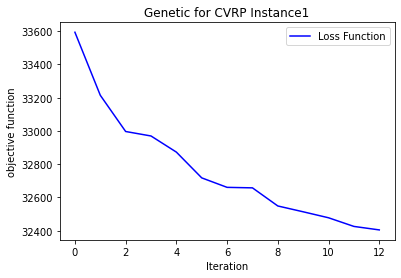

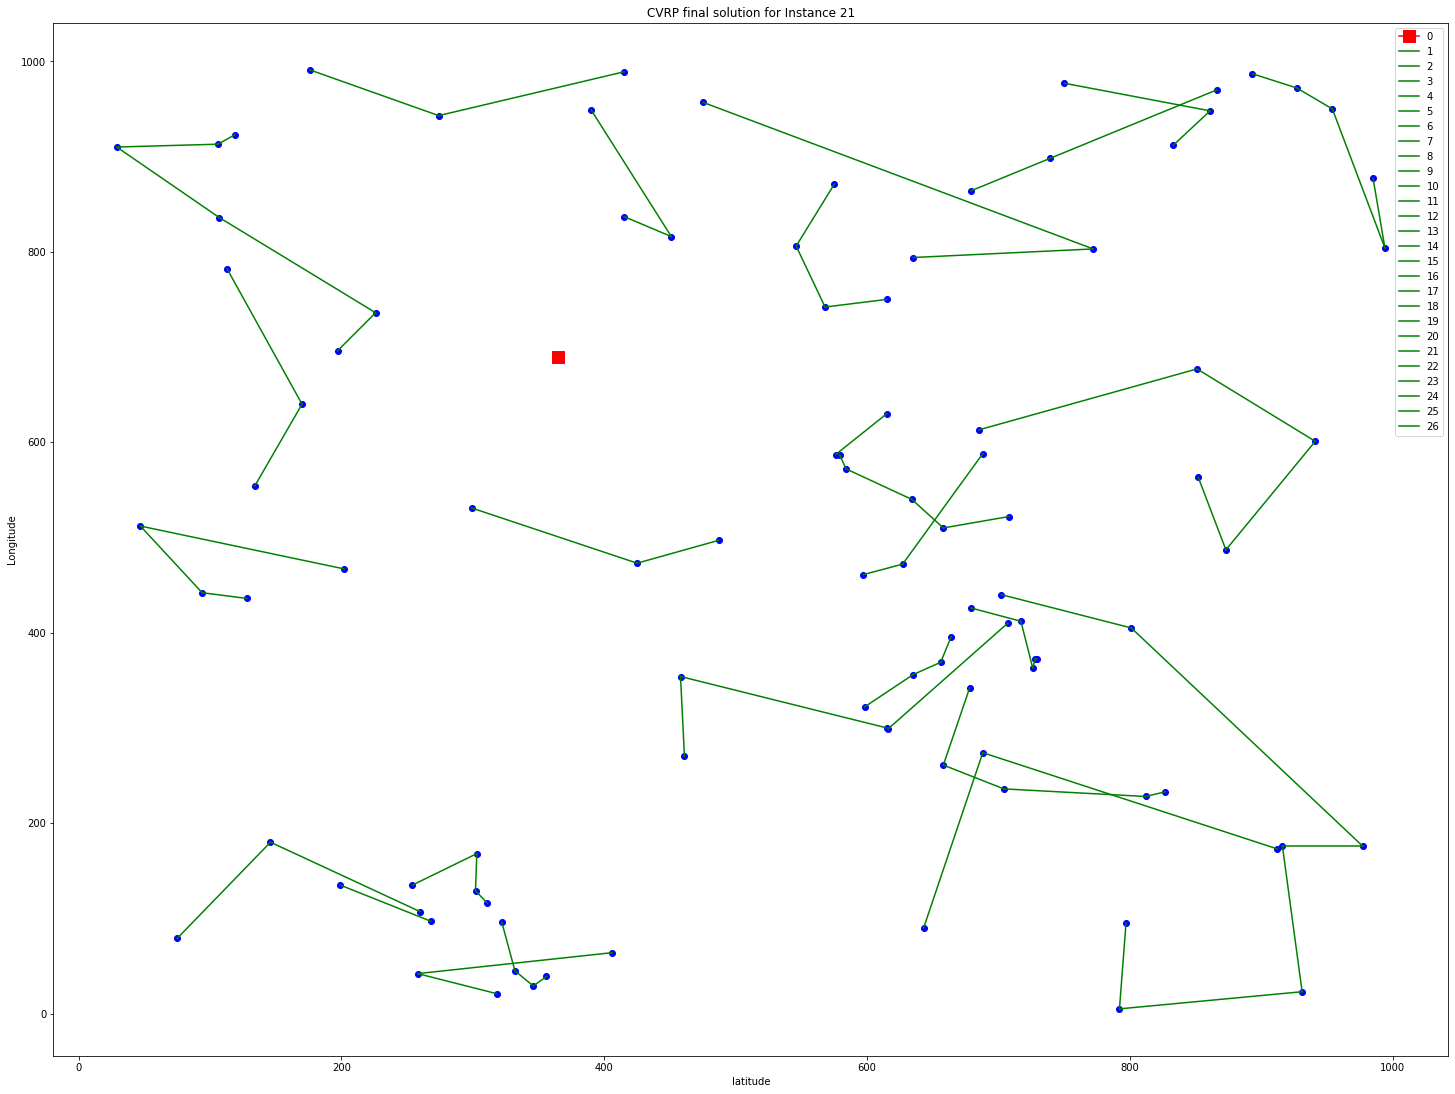

In [22]:
plt.plot(Loss,'b', label='Loss Function')
plt.title('Genetic for CVRP'+' Instance'+str(Instance))
plt.legend()
plt.ylabel('objective function')
plt.xlabel('Iteration')
plt.savefig('loss function_Genetic 1')


with open ('Genetic_Instance1-1.txt','w') as f:
    f.write('NO. Of Instance: '+str(Instance)+'\n')
    f.write('Instance Parameters: '+'\n')
    f.write('Population size: '+str(Population_size)+'\n')
    f.write('Parents size: '+str(parents_size)+'\n')
    f.write('Children size: '+str(Child_pop_size)+'\n')
    f.write('Number of Iteration: '+str(Iteration)+'\n')
    f.write('Best Objective function: ' + str(Global_Optima_Function)+'\n' )
    f.write('Gap: ' + str(round(gap,2))+'%'+'\n' )
    f.writelines('CPU Time: '+str(Cpu_Time)+'\n')
    f.write('The total number of times that the objective function is evaluated: '+str(No_compute_cost)+'\n')
    f.write('Mutation Rate: '+str(Mutatuion_Rate)+'\n'+'No. of Mutation: '+str(mutation_counter)+'\n')
    f.write('Crossover Rate: '+str(Crossover_Rate)+'\n')
    f.write('No. Of Crossover for Copy Top Chromosome From Parents to Child: '+str(Cr_counter_Best_Chromosome)+'\n')
    f.write('No. Of Crossover for Optimised Crossover Strategy: '+str(Optimised_Crossover)+'\n')
    for row in Best_SoFar_Route.keys():
        f.writelines('Route No.'+str(row)+': '+str(Best_SoFar_Route[row])+'\n')

data_info = Parameters['data_information']
df  = Parameters['location']
clist  = Parameters['customer_list']
arc  = Parameters['coords']
x_d, y_d, x_c, y_c = coordinates(df, data_info)
arcs = [(i,j) for i in clist for j in clist if i!=j]
graph1, X = active_graph(Best_SoFar_Route, arc)
visible_node = [a for a in arcs if X[a]>0]
plt.figure(figsize=(25,19))
ax = plt.subplot(111)
plt.plot(x_d, y_d, 'r',marker ='s', Markersize=12 )
plt.scatter(x_c, y_c,c='b', marker='o')
k=0
groups = Best_SoFar_Route.keys()
for i,j in visible_node:
    plt.plot([df['x'][i], df['x'][j]],[df['y'][i], df['y'][j]],'g')

plt.title("CVRP final solution for Instance 21")
plt.ylabel("Longitude")
plt.xlabel("latitude")
plt.legend(groups)
plt.savefig('problem_Genetic1')

In [ ]:
 while sum(all_checked)!= n:
            a = Initial_Rout[j][-1]
            my_list = {}
            for b in H:
                if b not in node_visited_init:
                    if b!=a:
                        my_list[b]=Y[(a,b)]
            my_list_as = {k: v for k, v in sorted(my_list.items(), key=lambda item: item[1])}
            my_list_key = list(my_list_as.keys())
            my_list_value = list(my_list_as.values())
            index = 0
            node_ass = False
            rout_deman = [d[s] for s in Initial_Rout[j]]
            u = np.sum(rout_deman)
            while node_ass == False and index<=3:
                visit = my_list_key[index]
                if all_checked[visit-1]==False:
                    if u+d[visit] <= Q:
                        Initial_Rout[j].append(visit)
                        all_checked[visit-1]=True
                        u = u+d[visit]
                        a = visit
                        node_visited_init.append(visit)
                        node_ass = True
                        break
                index+=1
                if index >=len(my_list_key):
                    break
            node_not_visited = [e for e in H if e not in node_visited_init]
            node_not_vi_dem = [d[t] for t in node_not_visited]
            rout_deman = [d[w] for w in Initial_Rout[j]]
            slack = Q - np.sum(rout_deman)
            try:
                if slack < min(node_not_vi_dem) or index >=3:
                    j+=1
                    Initial_Rout[j] =[0]
                    r = random.sample(node_not_visited, 1)[0]
                    Initial_Rout[j].append(r)
                    node_visited_init.append(r)
                    all_checked[r-1] = True
            except: ValueError

In [ ]:
aaaa=[1,2,3,4,5]
bbbb=[2,3,4,5,6]